## Medical Image Registration with Brain NIfTI File and MNI Template

## Introduction
Medical image registration is a crucial process in medical imaging that aligns different images into a common coordinate system. It is especially important for comparing images from different modalities, patients, or time points. In this notebook, we will focus on registering a brain NIfTI image to the MNI (Montreal Neurological Institute) template, which serves as a standard space in neuroimaging studies.

### Objectives
- Understand the concept and theory of medical image registration.
- Explore the different types of image registration methods.
- Implement image registration using a brain NIfTI file and the MNI template.


### What is Image Registration?
Image registration involves transforming different sets of data into one coordinate system. The goal is to spatially align a source image (moving image) with a target image (fixed image), so that the anatomical structures correspond to the same locations.

Image registration is crucial in medical imaging for several reasons:

1. Consistency Across Studies: Aligns images to a common template (e.g., MNI) for comparing across patients, ensuring standardized analysis across different body parts, not just neuroimaging.

2. Integration of Multi-Modal Data: Combines data from different imaging modalities (e.g., MRI, CT, PET) to provide a comprehensive view of anatomy and function, aiding in diagnosis and treatment planning.

3. Longitudinal Analysis: Tracks changes over time (e.g., tumor growth or treatment response) by aligning scans from different time points, ensuring that observed changes are due to pathology and not patient positioning.

4. Accurate Surgical Planning: Aligns preoperative and intraoperative images, helping surgeons navigate in real time with higher precision.

5. Radiotherapy Planning: Ensures precise targeting of tumors by aligning planning images with real-time scans, adapting treatment to changes in patient anatomy.

6. Data Fusion in AI: Improves the accuracy of AI models by providing consistent spatial alignment across training datasets, crucial for combining features from different modalities.

7. Comparative Anatomy and Personalized Medicine: Enables cross-patient comparisons and tailored treatment plans by aligning individual anatomy with standard templates or adjusting templates for personalized care.

In short, image registration improves accuracy and consistency in diagnosis, treatment planning, and research, making it essential across all areas of medical imaging.

### Applications
- Comparing images from different patients or time points.
- Integrating data from different imaging modalities (e.g., MRI and PET).
- Mapping brain anatomy to a standard space, like the MNI template, for group analysis in neuroimaging studies.




### Key Terms
- **Fixed Image**: The reference image to which the moving image is aligned (e.g., the MNI template).
- **Moving Image**: The image that will be transformed to align with the fixed image (e.g., your brain NIfTI image).
- **Similarity Measure**: A metric to quantify how well the images align (e.g., Mutual Information, Cross-Correlation).


### Types of Image Registration

| **Type**                     | **Description**                                                                 | **Use Case**                                                |
|------------------------------|---------------------------------------------------------------------------------|-------------------------------------------------------------|
| Rigid                        | Translation + rotation, no scaling                                              | Aligning follow-up scans of the same patient                |
| Affine                       | Translation + rotation + scaling + shearing                                     | Aligning to a template, e.g., brain to MNI                   |
| Non-Rigid (Deformable)       | Complex deformations for local adjustments                                      | Correcting soft tissue deformations                         |
| Linear                       | Rigid or affine transformations                                                 | When simpler transformations suffice                        |
| Non-Linear                   | Allows complex transformations                                                  | For precise anatomical alignment                            |
| Intensity-Based              | Uses voxel intensity values for similarity measures                             | Multi-modal registration, e.g., CT to MRI                   |
| Feature-Based                | Uses landmarks or features for transformation                                   | When intensity varies widely, e.g., ultrasound to MRI       |
| Mono-Modal                   | Aligns images of the same modality                                              | Motion correction, follow-up scans                          |
| Multi-Modal                  | Aligns images from different modalities                                         | Combining structural and functional imaging                 |
| 3D-to-3D                     | Aligns 3D volumes                                                               | Aligning full brain scans, e.g., MRI to MRI                 |
| 2D-to-3D                     | Aligns 2D images with 3D data                                                    | Surgical navigation using real-time ultrasound              |
| Group-Wise                   | Aligns multiple images to a common reference                                    | Population-based neuroimaging studies                       |
| Atlas-Based                  | Uses a reference atlas to guide alignment                                       | Mapping to standard templates like MNI                      |


#### What is the MNI template? 

The MNI template refers to a standard brain template developed by the Montreal Neurological Institute (MNI). It provides a common spatial reference for brain imaging studies, allowing researchers to align and compare anatomical or functional data across different subjects. The MNI template is especially popular in neuroimaging for tasks like registration, segmentation, and normalization.

You can find more information here: https://www.lead-dbs.org/about-the-mni-spaces/

we can use the MNI template provided by `nilearn` with the `load_mni152_gm_template` function for this tutorial. This template is directly accessible, making it convenient for quickly loading an MNI standard space template, and it can be adjusted in resolution as needed (1mm or 2mm).

We perform registration using a combination of libraries in combination with `nibabel` and `nilearn`:

2. [skimage.registration](https://scikit-image.org/docs/stable/auto_examples/registration/plot_register_translation.html#sphx-glr-auto-examples-registration-plot-register-translation-py): `skimage.registration` is part of the scikit-image library and focuses on providing simple tools for image registration based on intensity patterns. It includes methods like phase cross-correlation, which can determine the relative shift between two images, making it effective for initial translations and simpler alignment tasks. While it may not be as advanced as other libraries like SimpleElastix or ants in handling complex deformations, it is highly efficient for quick and basic alignment. In this tutorial, skimage.registration is used for intensity-based registration, offering a lightweight and fast approach to test initial alignments before applying more sophisticated transformations.

5. [ants (Advanced Normalization Tools)](https://antspy.readthedocs.io/en/latest/core.html): `ants (Advanced Normalization Tools)` is a state-of-the-art library for performing precise image registration, particularly known for its non-linear transformations using methods like SyN (Symmetric Normalization). It is widely used in medical research for aligning images to standard anatomical templates, especially in neuroimaging where subtle anatomical variations must be accurately accounted for. In this tutorial, ants is utilized for non-rigid and atlas-based registration, making it essential for handling complex deformations between individual brain scans and the MNI template. Its capabilities extend beyond basic registration, providing powerful tools for refining alignment, making it highly suitable for research and clinical applications that require accurate mapping of anatomical structures.

In [1]:

import ants
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from scipy.ndimage import affine_transform
from skimage.registration import phase_cross_correlation
import os

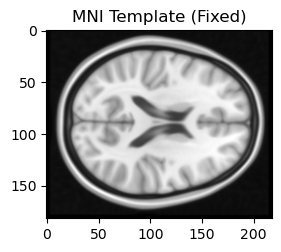

In [3]:

# Load the brain NIfTI image (moving) and MNI template (fixed) using ANTs
# Load the images into numpy for scikit-image and SimpleITK

mni_template_data = ants.image_read('MNI152_T1_1mm.nii.gz').numpy()
# brain_image_data_CT = ants.image_read('CT_MR_multimodal_registration/image_CT/desktop.ini').numpy()




# #Display initial images for comparison
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(brain_image_data_CT[:, :, brain_image_data_CT.shape[2] // 2], cmap='gray')
# plt.title('Brain Image (Moving)')

plt.subplot(1, 2, 2)
plt.imshow(mni_template_data[:, :, mni_template_data.shape[2] // 2], cmap='gray')
plt.title('MNI Template (Fixed)')
plt.show()


#### 1. Rigid Registration

Rigid registration is a technique used in image processing to align two or more images while preserving their shape and size. This method allows for only translation (shifting) and rotation, ensuring that the images remain intact without any deformation. 

##### Key Features:
- **Preservation of Geometry**: Since only rigid transformations are applied, the geometric integrity of the objects in the images is maintained.
- **Applications**: Commonly used in medical imaging to align scans from different modalities (e.g., CT and MRI) or to register images taken at different times of the same subject.
- **Transformation Parameters**: Involves calculating parameters such as translation vectors and rotation angles to achieve optimal alignment between images.

Rigid registration is particularly effective when the images being aligned are from the same anatomical structure or when no significant shape changes occur between the images.

In this code, we perform rigid registration on the brain image against the MNI template using ANTs. The result is saved and visualized, showcasing the aligned image in a specific slice for inspection.

In [4]:


# Perform rigid registration using ANTs
ants_rigid_result = ants.registration(fixed='MNI152_T1_1mm.nii.gz',)

# Save and display the result
# -- Your code here -- #
ants_rigid_result.to_filename('ants_rigid_result.nii.gz')
ants_rigid_result_data = ants_rigid_result.numpy()
plt.figure(figsize=(10, 5))
plt.imshow(ants_rigid_result_data[:, :, ants_rigid_result_data.shape[2] // 2], cmap='gray')
plt.title('Rigid Registration Result')
plt.show()




TypeError: registration() missing 1 required positional argument: 'moving'

#### 2. Affine Registration

Affine registration is an image alignment technique that builds upon rigid registration by allowing for additional transformations, including scaling and shearing, along with translation and rotation. This flexibility makes it suitable for aligning images where size or orientation differences are present, while still preserving the linearity of the structures within the images.

##### Key Features:
- **Increased Flexibility**: Allows for transformations that can scale and skew images, accommodating variations in size and shape.
- **Applications**: Frequently used in medical imaging to align images that may have different resolutions or when anatomical structures have changed over time.
- **Transformation Parameters**: Involves calculating a combination of translation vectors, rotation angles, scaling factors, and shear parameters to achieve optimal alignment.

Affine registration is particularly beneficial when the images being aligned are from the same anatomical structure but may differ in size, orientation, or aspect ratio.

In this code, we perform affine registration on the brain image against the MNI template using ANTs. The aligned image is saved and visualized, displaying a specific slice to evaluate the effectiveness of the registration.

In [ ]:
# Perform affine registration using ANTs
ants_affine_result = ants.registration(
   # -- Your code here -- #'
)

# Save and display the result
# -- Your code here -- #


#### 3. Non-rigid Registration


Non-rigid registration is an advanced image alignment technique that allows for flexible deformations of images, enabling the alignment of complex anatomical structures. Unlike rigid and affine registration, non-rigid registration accommodates local variations, making it particularly useful for aligning images where significant shape changes or anatomical differences exist.

##### Key Features:
- **Complex Deformations**: Enables local adjustments to the image, allowing for warping and bending to achieve accurate alignment.
- **Applications**: Commonly used in medical imaging to align anatomical structures that may vary between individuals or change over time, such as aligning brain scans in neuroimaging.
- **Transformation Techniques**: Often utilizes methods like **Symmetric Normalization (SyN)**, which optimizes the alignment through a combination of elastic deformations and global transformations.

Non-rigid registration is particularly effective when dealing with heterogeneous tissue structures or when the images represent the same anatomical region but exhibit variability in shape and size.

In this code, we perform non-rigid registration using ANTs with the SyN algorithm to align the brain image with the MNI template. The resulting image is saved and visualized, showcasing how the complex deformations improve the alignment accuracy.

In [ ]:
# Perform non-rigid registration using ANTs with 'SyN' transformation
ants_nonrigid_result = ants.registration(
   # -- Your code here -- #
)

# Save and display the result
# -- Your code here -- #

#### 4. Elastic Registration 

Elastic registration is a sophisticated image alignment technique that enables the deformation of images in a highly flexible manner, allowing for the alignment of complex structures while maintaining local tissue integrity. This method is particularly useful in applications where the anatomical differences between images are significant and cannot be adequately addressed by rigid or affine registration.

##### Key Features:
- **Localized Deformations**: Provides the ability to warp images elastically, allowing for detailed adjustments in specific areas without affecting the entire image.
- **Applications**: Frequently employed in medical imaging to align anatomical structures that may change shape due to pathology, treatment, or varying subject conditions, such as aligning soft tissue images in MRI.
- **Transformation Techniques**: Often implemented using advanced algorithms in the ANTs library, which optimize the alignment through a combination of global and local transformations.

Elastic registration is especially effective in scenarios where there are substantial variations in anatomy, as it allows for the precise alignment of tissues that may not conform to a uniform transformation model.

In this code, we perform elastic registration using ANTs to align the brain image with the MNI template. The resulting image is saved and visualized, demonstrating the effectiveness of the elastic deformations in achieving accurate alignment.

In [ ]:
# Perform elastic registration using ANTs
ants_elastic_result = ants.registration(
    # -- Your code here -- #
)

# Save and display the result
# -- Your code here -- #


#### 5. Intensity-based Registration

Intensity-based registration is an image alignment technique that focuses on the intensity patterns within the images to determine their optimal alignment. This approach analyzes the pixel or voxel intensity values to calculate the similarity between images, making it suitable for cases where anatomical landmarks are not easily identifiable.

##### Key Features:
- **Similarity Metrics**: Utilizes various metrics, such as cross-correlation or mutual information, to evaluate how well the intensity patterns in the moving image match those of the fixed image.
- **Applications**: Commonly used in medical imaging for tasks such as aligning images from different modalities or time points, especially when distinct features are not prominent.
- **Transformation Types**: Typically employs simpler transformations like rigid or affine transformations due to the reliance on intensity values rather than explicit anatomical landmarks.

Intensity-based registration is particularly advantageous when the images are similar in modality, as it can effectively leverage the intensity distributions to achieve accurate alignment.

In this code, we perform intensity-based registration using the `scikit-image` library to align the brain image with the MNI template. The registered image is saved and visualized, providing insight into the effectiveness of the intensity-based approach for this alignment task.

In [ ]:
# Step 1: Resample the brain image to match the shape of the MNI template
# Calculate zoom factors for resampling
zoom_factors = np.array(mni_template.shape) / np.array(brain_image.shape)
resampled_brain_image = zoom(brain_image, zoom_factors, order=3)  # Cubic interpolation

# Step 2: Compute transformation using phase cross-correlation for intensity-based registration
# Step 3: Apply the calculated shift using an affine transform
# Apply the translation using the calculated shift values
# Step 4: Visualize the registered image

# -- Your code here -- #

#### 6. 3D to 3D Registration

3D to 3D registration is an image alignment technique that involves aligning two three-dimensional images to ensure that corresponding structures match accurately in three-dimensional space. This process is essential in medical imaging and other applications where three-dimensional representations of objects or anatomy need to be compared or analyzed.

##### Key Features:
- **Spatial Alignment**: Focuses on aligning the 3D spatial coordinates of the moving image with those of the fixed image, ensuring that all dimensions are accounted for.
- **Applications**: Commonly used in medical imaging to align different scans of the same subject, such as CT and MRI scans, or to match pre- and post-treatment images to assess changes in anatomy.
- **Transformation Types**: Can utilize various transformation models, including rigid, affine, or non-rigid transformations, depending on the nature of the images and the required precision of alignment.

3D to 3D registration is particularly beneficial when dealing with complex structures in three-dimensional space, as it enables accurate comparisons and assessments of anatomical changes.

In this code, we perform 3D to 3D registration using ANTs to align the brain image with the MNI template. The resulting registered image is saved and visualized, illustrating the effectiveness of the 3D alignment process in accurately matching anatomical structures.

In [ ]:
# Load images using SimpleITK directly
brain_image_sitk = sitk.ReadImage(brain_image_path)
mni_template_sitk = sitk.ReadImage(mni_template_path)

# Step 1: Ensure both images are of the same type (e.g., both are float32)
brain_image_sitk = sitk.Cast(brain_image_sitk, sitk.sitkFloat32)
mni_template_sitk = sitk.Cast(mni_template_sitk, sitk.sitkFloat32)

# Step 2: Set up the registration method with affine transformation and mutual information
# -- Your code here -- #

# Use a multi-resolution strategy: start with lower resolution and refine
# -- Your code here -- #

# Use gradient descent optimizer for affine transformation
registration_method.SetOptimizerAsGradientDescent(
    # -- Your code here -- #
)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Step 3: Initialize the transform based on the image centers
initial_transform = sitk.CenteredTransformInitializer(
    # -- Your code here -- #
)
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Step 4: Perform the registration
# -- Your code here -- #

# Step 5: Resample the brain image using the obtained transform
resampled_image = sitk.Resample(
    # -- Your code here -- #
)

# Step 6: Convert the resampled image back to NumPy for visualization
# -- Your code here -- #

# Visualize the middle slice of the registered image
# Save the registered image

# -- Your code here -- #

#### 7. Atlas-based Registration

Atlas-based registration is an image alignment technique that uses a pre-defined anatomical atlas as a reference to align other images. This method leverages the knowledge contained in the atlas to achieve accurate registration by mapping the target image to the atlas, which serves as a standardized representation of anatomical structures.

##### Key Features:
- **Standardized Reference**: Utilizes a detailed anatomical atlas that represents average or typical anatomical features, providing a common framework for alignment.
- **Applications**: Commonly employed in medical imaging to register patient scans to a standard anatomical framework, facilitating comparisons across subjects and studies, particularly in neuroimaging.
- **Transformation Techniques**: Often involves complex transformations, including non-rigid and elastic deformations, to accurately align the target image with the atlas while accommodating anatomical variations.

Atlas-based registration is particularly useful in scenarios where anatomical variability exists, as it allows for precise alignment by leveraging a comprehensive anatomical model.

In this code, we perform atlas-based registration using ANTs to align the brain image with the MNI template. The registered image is saved and visualized, showcasing the effectiveness of using an atlas as a reference for achieving accurate anatomical alignment.

In [ ]:
# Use ANTs to align the brain image to a standard MNI atlas using 'SyN'
ants_atlas_result = ants.registration(
    # -- Your code here -- #
)

# Save and display the result
# -- Your code here -- #

#### 8. Hybrid registration

Hybrid registration is an advanced image alignment technique that combines multiple registration approaches to achieve more accurate and robust results. This method integrates different strategies, such as intensity-based and feature-based registration, to leverage the strengths of each technique, ensuring optimal alignment of images.

##### Key Features:
- **Multi-Modal Integration**: Combines different registration methods, allowing for improved accuracy by utilizing both intensity information and anatomical features.
- **Applications**: Commonly used in medical imaging to align images from different modalities (e.g., CT, MRI, PET) or to refine alignments when dealing with complex anatomical structures.
- **Flexibility**: Adapts to varying conditions in image data, making it suitable for complex registration tasks where single-method approaches may fall short.

Hybrid registration is particularly beneficial when aligning images that exhibit both intensity variations and distinct anatomical features, as it enhances the robustness of the registration process.

In this code, we perform hybrid registration using ANTs to align the brain image with the MNI template. The registered image is saved and visualized, demonstrating the effectiveness of combining multiple registration strategies for improved anatomical alignment.

In [ ]:
# Use 'SyNRA' for a hybrid approach that includes rigid alignment before non-rigid
ants_hybrid_result = ants.registration(
    # -- Your code here -- #

# Save and display the result
# -- Your code here -- #


### Similarity Measures

- **Mutual Information (MI)**: Measures the statistical dependence between image intensities, making it particularly useful for multi-modality registration (e.g., aligning MRI with CT scans). Higher values indicate a greater level of shared information between the images, suggesting better alignment.

- **Normalized Mutual Information (NMI)**: A variant of MI that normalizes the mutual information score, allowing for comparison across different image pairs. NMI values range from 0 to 1, where values closer to 1 indicate better alignment, while values near 0 suggest little to no correlation.

- **Normalized Cross-Correlation (NCC)**: Evaluates the similarity of intensity patterns in the images, normalized to mitigate the effects of variations in brightness or contrast. NCC values range from -1 to 1, with values closer to 1 indicating a strong correlation and better alignment.

- **Mean Squared Error (MSE)**: Calculates the average squared difference between corresponding voxel values, making it suitable for mono-modal registration where images are similar in modality. Lower MSE values indicate better alignment, as they reflect smaller differences between the images.

- **Structural Similarity Index (SSIM)**: Measures the perceptual similarity between two images based on luminance, contrast, and structure. SSIM values range from -1 to 1, with values closer to 1 indicating greater structural similarity and better alignment between the images.

In [ ]:
# Load images as numpy arrays
# Ensure that all images and the MNI template have the same dimensions.
# For demonstration purposes, let's assume the following variables hold the registered results:
# mni_template - the fixed MNI template image as a NumPy array
# rigid_result_image, affine_result_image, nonrigid_result_image, elastic_result_image, intensity_translated_image - registered images as NumPy arrays

# Flatten the images for calculation (except for SSIM)
mni_flat = mni_template.ravel()

def compute_metrics(moving_image, fixed_image):
    # Flatten moving image
    
    
    # -- Your code here -- #


    return {
        "MSE": mse_value,
        "NCC": ncc_value,
        "MI": mi_value,
        "NMI": nmi_value,
        "SSIM": ssim_value
    }

# Calculate metrics for each registration method
# Print the results and visualise as bar plot

# -- Your code here -- #

### Coding Project -  **Multi-Modal Registration Between MRI and CT Brain DICOMs**

**Objective:**  
Perform multi-modal registration between MRI and CT brain DICOM images using various registration techniques. The goal is to achieve accurate anatomical alignment between the two imaging modalities and evaluate the quality of registration using appropriate similarity metrics.

1. **Multi-Modal Registration Techniques:**  
   - Implement different registration methods to align the MRI (moving image) to the CT (fixed image). Focus on techniques that can handle the challenges of multi-modal data.

2. **Evaluate Registration Quality:**  
   - Calculate the following similarity metrics for each registration method to assess the quality of the alignment.

3. **Analysis and Comparison:**  
   - Compare the similarity metrics across the different registration methods.
   - Analyze which registration technique provides the most accurate anatomical alignment between the MRI and CT images based on the calculated metrics.


##### Considerations for Multi-Modal Registration between MRI and CT:

- **CT and Hounsfield Units (HU):**  
  CT images use HU to represent tissue densities (e.g., air, bone, soft tissue), while MRI uses arbitrary intensity scales. Adjusting or normalizing the CT values can improve alignment with MRI.

- **Contrast Differences:**  
  MRI is better for soft tissue detail, while CT highlights bone. Selecting appropriate registration methods that handle these differences is crucial.

- **Preprocessing Needs:**  
  Resampling images to a common resolution and possibly skull-stripping can focus the registration on brain tissues.

- **Landmark Visibility:**  
  Use visible landmarks in both modalities for feature-based methods, ensuring alignment accuracy.

- **Impact on Metrics:**  
  Metrics like **MI** and **NMI** are effective for multi-modal evaluation, while **MSE** and **SSIM** may require adjustments. Visual checks can also help validate results.